In [1]:
from neo4j import GraphDatabase

url = 'bolt://localhost:7687'
username = 'neo4j'
password = 'letmein'

# Connect to Neo4j
driver = GraphDatabase.driver(url, auth=(username, password))

In [2]:
import pandas as pd

def run_query(query):
    with driver.session() as session:
        result = session.run(query)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())

In [3]:
run_query("""
RETURN gds.version() 
""")

,gds.version()
0,2.1.6


In [4]:
run_query("""
CREATE CONSTRAINT IF NOT EXISTS ON (s:Stream) ASSERT s.id IS UNIQUE;
""")

""


In [5]:
run_query("""
LOAD CSV WITH HEADERS FROM "https://bit.ly/3JjgKgZ" AS row
MERGE (s:Stream {id: row.id})
SET s.language = row.language
""")

""


In [6]:
run_query("""
USING PERIODIC COMMIT 10000
LOAD CSV WITH HEADERS FROM "https://bit.ly/3S9Uyd8" AS row
MATCH (s:Stream {id:row.source})
MATCH (t:Stream {id:row.target})
MERGE (s)-[r:SHARED_AUDIENCE]->(t)
SET r.weight = toInteger(row.weight)
""")

""


In [7]:
run_query("""
CALL gds.graph.project("twitch", "Stream", 
  {SHARED_AUDIENCE: {orientation: "UNDIRECTED", properties:["weight"]}})
""")

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'Stream': {'label': 'Stream', 'properties': {}}}",{'SHARED_AUDIENCE': {'orientation': 'UNDIRECTE...,twitch,3721,262854,139


In [8]:
run_query("""
CALL gds.beta.node2vec.write('twitch', 
  {embeddingDimension:8, relationshipWeightProperty:'weight',
   inOutFactor:2, returnFactor:1, writeProperty:'node2vec'})
""")


,nodeCount,nodePropertiesWritten,preProcessingMillis,computeMillis,writeMillis,configuration,lossPerIteration
0,3721,3721,0,10657,124,"{'negativeSamplingExponent': 0.75, 'initialLea...",[402907.44772462314]


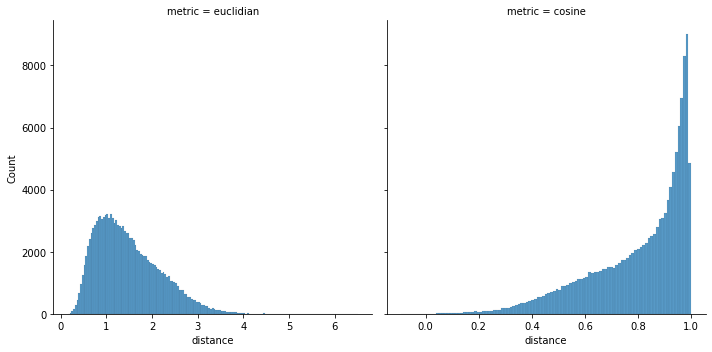

In [9]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]
import seaborn as sns

df = run_query("""
MATCH (c1:Stream)-[:SHARED_AUDIENCE]->(c2:Stream)
RETURN gds.similarity.euclideanDistance(c1.node2vec, c2.node2vec) AS distance, 'euclidian' as metric
UNION
MATCH (c1:Stream)-[:SHARED_AUDIENCE]->(c2:Stream)
RETURN gds.similarity.cosine(c1.node2vec, c2.node2vec) AS distance, 'cosine' as metric
""")

sns.displot(data=df, x='distance', col='metric', common_bins=False, facet_kws=dict(sharex=False))

<AxesSubplot:xlabel='cosineSimilarity', ylabel='avgDegree'>

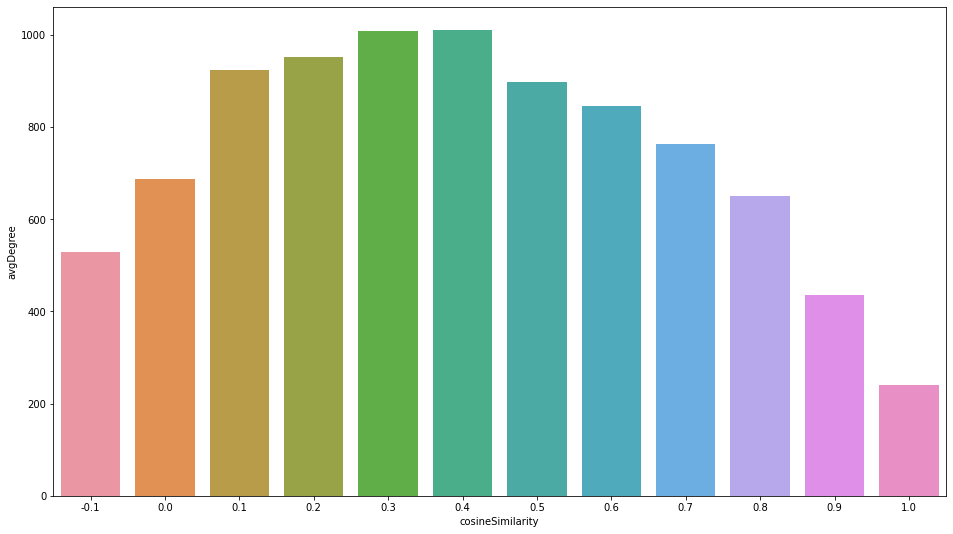

In [10]:
df = run_query("""
MATCH (c1:Stream)-[:SHARED_AUDIENCE]->(c2:Stream)
WITH c1, c2, gds.similarity.cosine(c1.node2vec, c2.node2vec) AS cosineSimilarity,
     size((c1)-[:SHARED_AUDIENCE]-()) AS degree1,
     size((c2)-[:SHARED_AUDIENCE]-()) AS degree2
RETURN round(cosineSimilarity,1) AS cosineSimilarity, avg(degree1 + degree2) AS avgDegree
ORDER BY cosineSimilarity
""")

sns.barplot(data=df, x='cosineSimilarity', y='avgDegree')

In [11]:
data = run_query("""
MATCH (s:Stream)
RETURN s.id AS streamId, s.language AS language, s.node2vec AS embedding
""")

In [12]:
data['output'] = pd.factorize(data['language'])[0]


In [13]:
data.head()

,streamId,language,embedding,output
0,129004176,en,"[0.6173518896102905, -0.9405122995376587, -0.6...",0
1,26490481,en,"[0.06576687842607498, -1.2238984107971191, 0.1...",0
2,213749122,en,"[-0.6708614230155945, -0.6137220859527588, 0.1...",0
3,30104304,en,"[0.10196232795715332, -0.4216100573539734, 1.1...",0
4,160504245,en,"[0.21248988807201385, -0.7548245787620544, 0.6...",0


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X = data['embedding'].to_list()
y = data['output'].to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

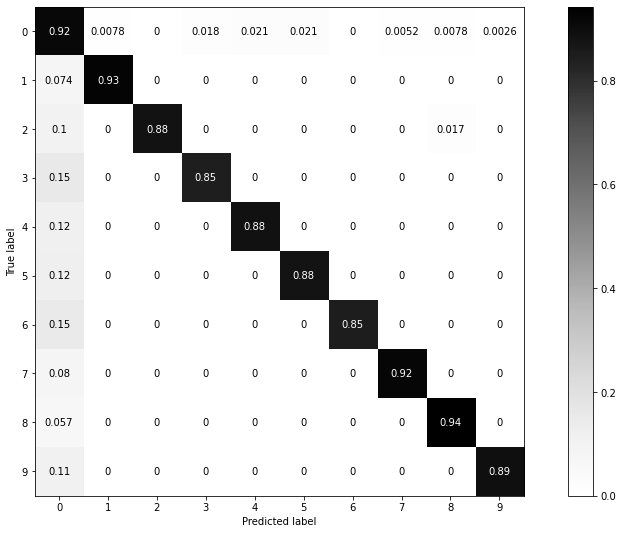

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = rfc.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize= 'true', cmap='Greys')

In [16]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       384
           1       0.94      0.93      0.93        54
           2       1.00      0.88      0.94        59
           3       0.82      0.85      0.84        39
           4       0.85      0.88      0.87        52
           5       0.86      0.88      0.87        58
           6       1.00      0.85      0.92        20
           7       0.92      0.92      0.92        25
           8       0.89      0.94      0.92        35
           9       0.94      0.89      0.92        19

    accuracy                           0.90       745
   macro avg       0.91      0.89      0.90       745
weighted avg       0.91      0.90      0.90       745



In [17]:
run_query("""
CALL gds.graph.drop('twitch')
""")

,graphName,database,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema
0,twitch,neo4j,,-1,3721,262854,{'relationshipProjection': {'SHARED_AUDIENCE':...,0.018989,2022-08-10T14:05:28.045920000+02:00,2022-08-10T14:05:28.184534000+02:00,"{'graphProperties': {}, 'relationships': {'SHA..."
